In [1]:
import duckdb
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
con = duckdb.connect('/mnt/s/FAFSA/FAFSA.db')

In [3]:
con.execute("""SELECT * FROM taxa_pairs LIMIT 1""").df()

,query_id,subject_id,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,local_E_value,query_align_start,query_align_end,subject_align_end,subject_align_start,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,__index_level_0__
0,1281767,1413211,0.971045,0.865324,0.892278,0.0,178,1589,1486,73,1412,0.888609,1414,0.947086,1283.0,0


In [4]:
con.execute("""SELECT * FROM taxa LIMIT 1""").df()

,taxid,16s_seq,16s_len,temperature,superkingdom,phylum,class,order,family,genus,__index_level_0__
0,617123,GATGAACGCTGGCGGCGTGCTTAACACATGCAAGTCGAACGAAGCT...,1594,37.0,2.0,1239.0,186801.0,186802.0,186803.0,1164882.0,0


In [5]:
con.execute("""SELECT * FROM protein_pairs LIMIT 1""").df()

,thermo_pid,meso_pid,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,local_E_value,query_align_start,query_align_end,subject_align_end,subject_align_start,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,thermo_taxid,meso_taxid
0,A0A2W7SG91,A0A1K1NK60,0.391026,0.386076,0.389776,2.130000e-32,1,158,153,1,158,1.0,153,0.987097,271.0,1004304,1004


In [6]:
con.execute("""SELECT * FROM proteins LIMIT 1""").df()

,pid,taxid,pdb_id,alphafold_id,proteome,protein_seq
0,A0A2A5R0G1,373386,NaN,A0A2A5R0G1,UP000219689,MLADLLSESYATDLEESWENERTATPVRAFAVRLHQTGCSLRETTT...


### Distribution of ogt diff for taxa pairs

In [57]:
ogt_list = con.execute("""SELECT m_taxa.temperature AS meso_ogt,
                          t_taxa.temperature AS thermo_ogt,
                          thermo_ogt - meso_ogt AS ogt_diff
                          FROM taxa_pairs
                          JOIN taxa AS m_taxa ON (taxa_pairs.subject_id = m_taxa.taxid)
                          JOIN taxa AS t_taxa ON (taxa_pairs.query_id = t_taxa.taxid)
                          """).fetchnumpy()

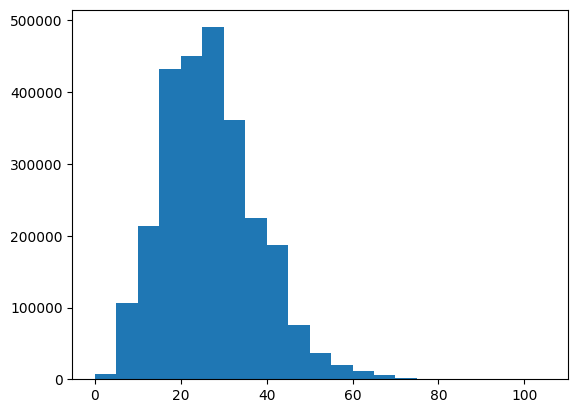

In [60]:
bins = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80, 85, 90, 95, 100, 105]
n, bins, _ = plt.hist(ogt_list['ogt_diff'], bins = bins)

In [61]:
bins

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.])

In [62]:
data = {'Bins':bins[:-1], 'Counts':n}
ogt_diff_prot = pd.DataFrame(data)
ogt_diff_prot.to_csv('/mnt/c/Users/Ryan/Desktop/l2t/taxa_ogt_diff_hist.csv')

### Distribution of ogt diff in protein pairs

In [63]:
ogt_diff_effect = con.execute("""SELECT m_taxa.temperature AS meso_ogt,
                          t_taxa.temperature AS thermo_ogt,
                          thermo_ogt - meso_ogt AS ogt_diff
                          FROM protein_pairs
                          JOIN taxa AS m_taxa ON (protein_pairs.meso_taxid = m_taxa.taxid)
                          JOIN taxa AS t_taxa ON (protein_pairs.thermo_taxid = t_taxa.taxid)
                          """).fetchnumpy()

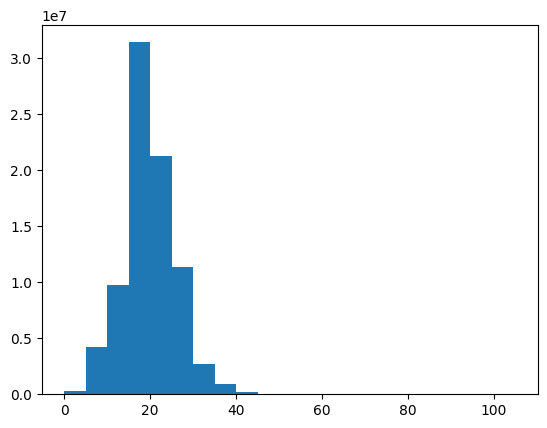

In [64]:
n, bins, _ = plt.hist(ogt_diff_effect['ogt_diff'], bins = bins)

data = {'Bins':bins[:-1], 'Counts':n}
ogt_diff_prot = pd.DataFrame(data)
ogt_diff_prot.to_csv('/mnt/c/Users/Ryan/Desktop/l2t/protein_ogt_diff_hist.csv')

### Effect of ogt diff filtering on protein pairs

In [72]:
remaining = []

for i in range(70):
    remaining.append(np.sum(ogt_diff_effect['ogt_diff'] >= i))

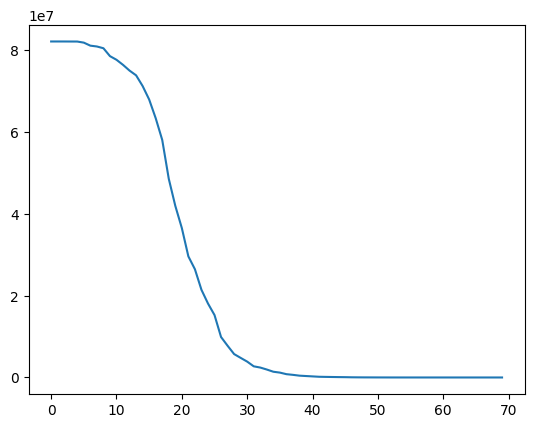

In [78]:
plt.plot(remaining)

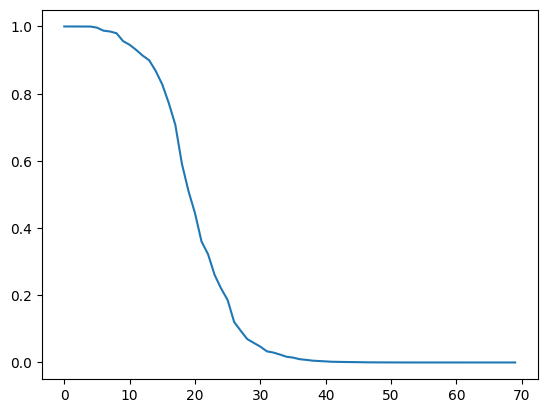

In [79]:
remaining_pct = [i/len(ogt_diff_effect['ogt_diff']) for i in remaining]
plt.plot(remaining_pct)

In [80]:
rem = {'dT':range(70), 'remaining':remaining, 'pct':remaining_pct}

remaining_df = pd.DataFrame(rem)
remaining_df.to_csv('/mnt/c/Users/Ryan/Desktop/l2t/pairs_remaining_ogt.csv')

### Number of protein hits vs 16S read length

In [81]:
cmd = """SELECT "16s_len",
         temperature < 40 AS meso,
         (SELECT COUNT(taxid)
         FROM proteins
         WHERE taxid = taxa.taxid) AS num_prot
         FROM taxa
         """

proteins_vs_16s = con.execute(cmd).df()

In [82]:
proteins_vs_16s.head()

,16s_len,meso,num_prot
0,1594,True,2392
1,1589,False,2415
2,1589,True,3612
3,1589,True,0
4,1588,True,5269


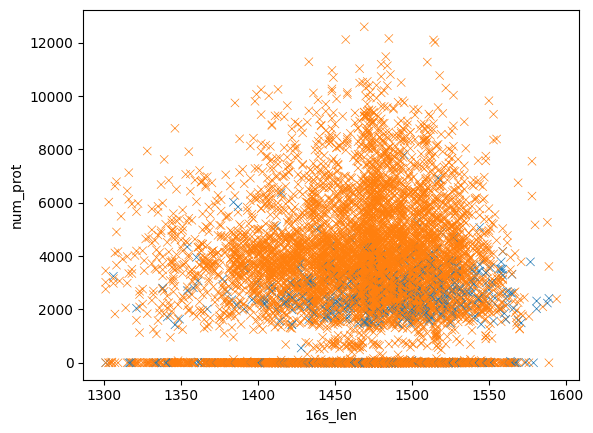

In [83]:
sns.scatterplot(data = proteins_vs_16s, x = '16s_len', y = 'num_prot', hue = 'meso', style = True, legend = False, markers = 'x');

In [94]:
p_vs_16s_thermo = proteins_vs_16s[proteins_vs_16s['meso']==False]
p_vs_16s_meso = proteins_vs_16s[proteins_vs_16s['meso']==True]
p_vs_16s_thermo.to_csv('/mnt/c/Users/Ryan/Desktop/l2t/p_vs_16s_thermo.csv')
p_vs_16s_meso.to_csv('/mnt/c/Users/Ryan/Desktop/l2t/p_vs_16s_meso.csv')

In [95]:
cmd = """SELECT "16s_len",
         temperature < 40 AS meso,
         (SELECT COUNT(taxid)
         FROM proteins
         WHERE taxid = taxa.taxid) AS num_prot
         FROM taxa
         WHERE num_prot >0
         """

proteins_vs_16s_clean = con.execute(cmd).df()

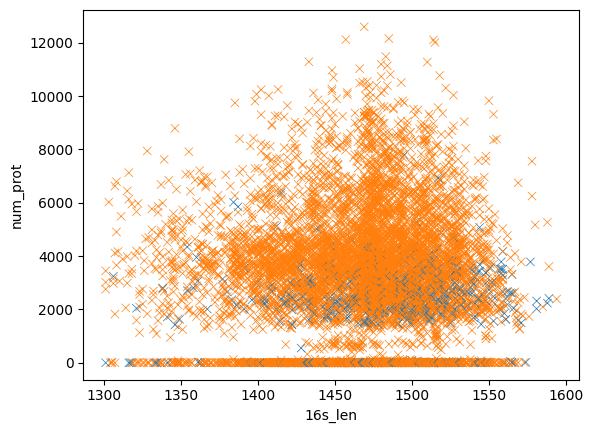

In [96]:
sns.scatterplot(data = proteins_vs_16s_clean, x = '16s_len', y = 'num_prot', hue = 'meso', style = True, legend = False, markers = 'x');

In [98]:
p_vs_16s_thermo_cln = proteins_vs_16s_clean[proteins_vs_16s_clean['meso']==False]
p_vs_16s_meso_cln = proteins_vs_16s_clean[proteins_vs_16s_clean['meso']==True]
p_vs_16s_thermo_cln.to_csv('/mnt/c/Users/Ryan/Desktop/l2t/p_vs_16s_thermo_cln.csv')
p_vs_16s_meso_cln.to_csv('/mnt/c/Users/Ryan/Desktop/l2t/p_vs_16s_meso_cln.csv')

In [20]:
cmd = """SELECT "16s_len",
         temperature < 40 AS meso,
         (SELECT COUNT(taxid)
         FROM proteins
         WHERE taxid = taxa.taxid) AS num_prot
         FROM taxa
         WHERE num_prot <50
         AND num_prot >0
         """

proteins_vs_16s_low = con.execute(cmd).df()

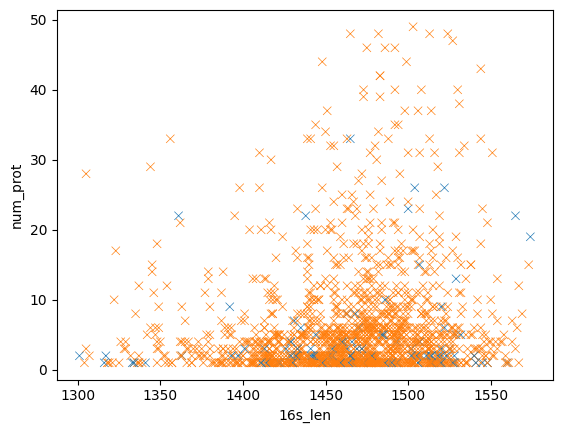

In [21]:
sns.scatterplot(data = proteins_vs_16s_low, x = '16s_len', y = 'num_prot', hue = 'meso', style = True, legend = False, markers = 'x');

In [22]:
len(proteins_vs_16s)-len(proteins_vs_16s_clean)

2038

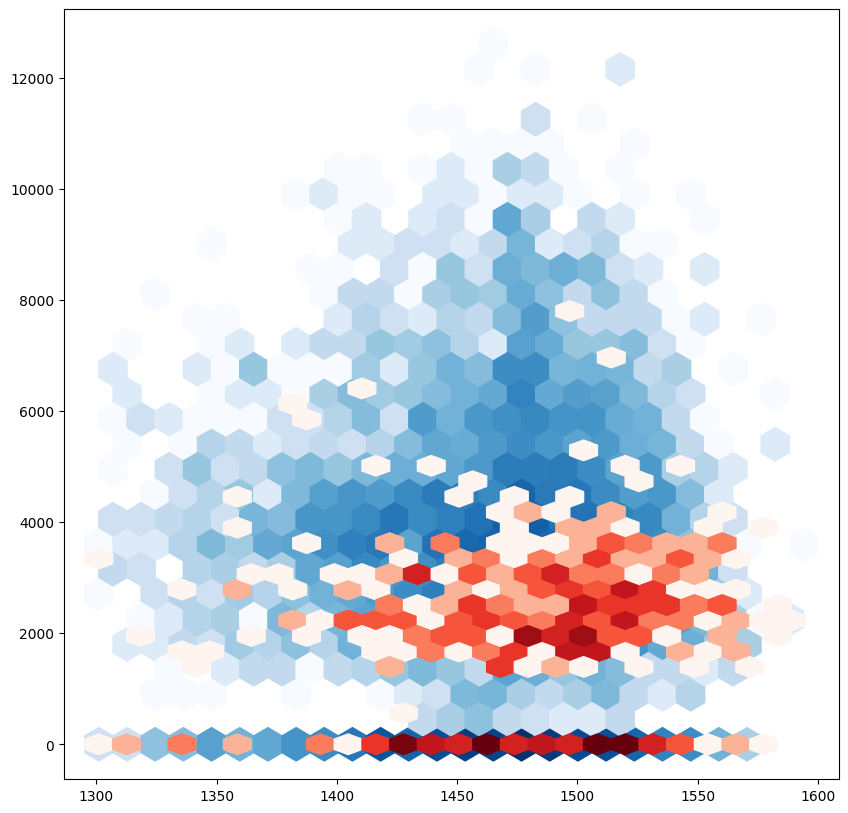

In [112]:
fig, ax = plt.subplots(figsize = (10,10))

ax.hexbin(x = p_vs_16s_meso_cln['16s_len'], y = p_vs_16s_meso_cln['num_prot'], bins = 'log', cmap = 'Blues', gridsize = 25)
ax.hexbin(x = p_vs_16s_thermo_cln['16s_len'], y = p_vs_16s_thermo_cln['num_prot'], bins = 'log', cmap = 'Reds', gridsize = 25)

### Number of pairs per taxa

In [ ]:
cmd = """SELECT taxid,
         (SELECT COUNT(meso_taxid) FROM protein_pairs
         WHERE meso_taxid = taxid) AS meso_count,
         (SELECT COUNT(thermo_taxid) FROM protein_pairs
         WHERE thermo_taxid = taxid) AS thermo_count
         FROM taxa
         WHERE meso_count != 0
         OR thermo_count != 0
         """

taxa_num_pairs = con.execute(cmd).df()

In [ ]:
taxa_num_pairs

In [ ]:
# Double check

m = con.execute("""SELECT COUNT(DISTINCT meso_taxid) FROM protein_pairs""").df()
t = con.execute("""SELECT COUNT(DISTINCT thermo_taxid) FROM protein_pairs""").df()

print(m.values + t.values)

**There are 5002 meso taxa and 243 thermo taxa represented with pairs**

In [ ]:
mesos = taxa_num_pairs[taxa_num_pairs['meso_count'] > 0]
thermos = taxa_num_pairs[taxa_num_pairs['thermo_count'] > 0]

In [ ]:
sns.histplot(x = mesos['meso_count'], bins = 10)
sns.histplot(x = thermos['thermo_count'], bins = 10)


In [ ]:
con.close()

### Proportion of proteins from taxa with >1000 proteins that are in pairs

In [157]:
cmd = """SELECT taxid,
         (SELECT COUNT(taxid) FROM proteins
          WHERE taxa.taxid = proteins.taxid) 
          AS num_prot,
         (SELECT COUNT(DISTINCT meso_pid) FROM protein_pairs
          WHERE taxa.taxid = protein_pairs.meso_taxid) +
         (SELECT COUNT(DISTINCT thermo_pid) FROM protein_pairs
          WHERE taxa.taxid = protein_pairs.thermo_taxid) 
          AS num_in_pair
         FROM taxa
         WHERE num_prot >= 1000"""

prot_rep = con.execute(cmd).df()

prot_rep['prop'] = prot_rep['num_in_pair']/prot_rep['num_prot']

n, bins, _ = plt.hist(prot_rep['prop'], bins = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
data = {'Bins':bins[:-1], 'Counts':n}
prot_rep_taxa = pd.DataFrame(data)
prot_rep_taxa.to_csv('/mnt/c/Users/Ryan/Desktop/l2t/protein_rep_taxa_hist.csv')

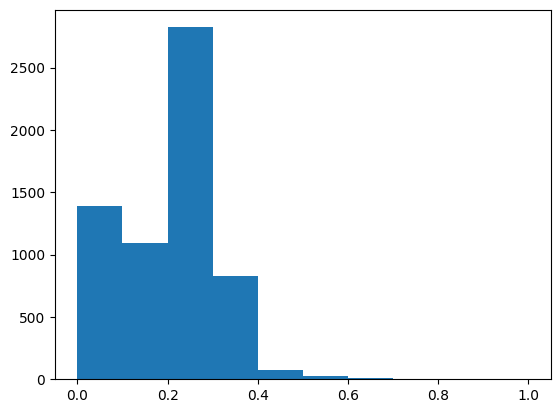

In [166]:
cmd = """SELECT taxid,
         (SELECT COUNT(taxid) FROM proteins
          WHERE taxa.taxid = proteins.taxid) 
          AS num_prot,
         (SELECT COUNT(DISTINCT meso_pid) FROM protein_pairs
          WHERE taxa.taxid = protein_pairs.meso_taxid) +
         (SELECT COUNT(DISTINCT thermo_pid) FROM protein_pairs
          WHERE taxa.taxid = protein_pairs.thermo_taxid) 
          AS num_in_pair
         FROM taxa
         WHERE num_prot >= 10
         """

prot_rep = con.execute(cmd).df()

prot_rep['prop'] = prot_rep['num_in_pair']/prot_rep['num_prot']

n, bins, _ = plt.hist(prot_rep['prop'], bins = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
data = {'Bins':bins[:-1], 'Counts':n}
prot_rep_taxa = pd.DataFrame(data)
prot_rep_taxa.to_csv('/mnt/c/Users/Ryan/Desktop/l2t/protein_rep_taxa_hist_nofilt.csv')

### Remake scatterplot with only used proteins

In [172]:
m_cmd = """SELECT taxid,
         "16s_len",
         (SELECT COUNT(taxid) FROM proteins
          WHERE taxa.taxid = proteins.taxid) 
          AS num_prot,
         (SELECT COUNT(DISTINCT meso_pid) FROM protein_pairs
          WHERE taxa.taxid = protein_pairs.meso_taxid) 
          AS num_in_pair
         FROM taxa
         WHERE num_in_pair > 0
         """
t_cmd = """SELECT taxid,
         "16s_len",
         (SELECT COUNT(taxid) FROM proteins
          WHERE taxa.taxid = proteins.taxid) 
          AS num_prot,
         (SELECT COUNT(DISTINCT thermo_pid) FROM protein_pairs
          WHERE taxa.taxid = protein_pairs.thermo_taxid) 
          AS num_in_pair
         FROM taxa
         WHERE num_in_pair > 0
         """
m_used_prot_rep = con.execute(m_cmd).df()
t_used_prot_rep = con.execute(t_cmd).df()

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

In [173]:
m_used_prot_rep.head()

,taxid,16s_len,num_prot,num_in_pair
0,1485586,1588,5269,1243
1,334543,1585,2099,344
2,380084,1580,5173,923
3,67345,1578,6251,1644
4,68230,1578,7558,1768


In [174]:
m_used_prot_rep.to_csv('/mnt/c/Users/Ryan/Desktop/l2t/meso_used_protein_vs_16s_no_0.csv')
t_used_prot_rep.to_csv('/mnt/c/Users/Ryan/Desktop/l2t/thermo_used_protein_vs_16s_no_0.csv')

### 16S % ID match vs number of pairs

In [206]:
cmd = """SELECT scaled_local_symmetric_percent_id,
         (SELECT COUNT(meso_taxid)
          FROM protein_pairs
          WHERE taxa_pairs.query_id = thermo_taxid
          AND taxa_pairs.subject_id = meso_taxid)
         AS num_pairs
         FROM taxa_pairs
         WHERE scaled_local_symmetric_percent_id > 0.85
         AND query_align_cov > 0.9
         AND subject_align_cov > 0.9
         """

taxa_match_vs_num_pairs = con.execute(cmd).df()

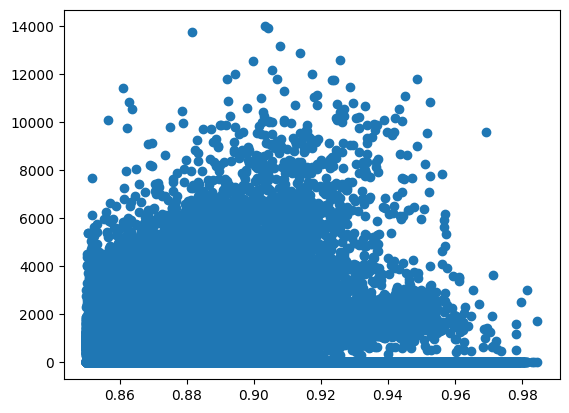

In [212]:
plt.scatter(taxa_match_vs_num_pairs['scaled_local_symmetric_percent_id'], taxa_match_vs_num_pairs['num_pairs'])

In [209]:
taxa_match_vs_num_pairs.to_csv('/mnt/c/Users/Ryan/Desktop/l2t/taxa_pairs_16S_id_vs_num_pairs.csv')

In [207]:
taxa_match_vs_num_pairs.shape

(105285, 2)

**Now scale for each pairwise space**

In [247]:
cmd = """SELECT scaled_local_symmetric_percent_id,
         (SELECT COUNT(meso_taxid)
          FROM protein_pairs
          WHERE taxa_pairs.query_id = thermo_taxid
          AND taxa_pairs.subject_id = meso_taxid) AS num_pairs,
         (SELECT COUNT(taxid)
           FROM proteins
           WHERE taxa_pairs.query_id = proteins.taxid) AS t_hit,
         (SELECT COUNT(taxid)
          FROM proteins
          WHERE taxa_pairs.subject_id = proteins.taxid) AS m_hit
         FROM taxa_pairs
         WHERE scaled_local_symmetric_percent_id > 0.85
         AND query_align_cov > 0.9
         AND subject_align_cov > 0.9
         AND m_hit > 25
         AND t_hit > 25
         """

taxa_match_vs_num_pairs_scaled = con.execute(cmd).df()

In [248]:
taxa_match_vs_num_pairs_scaled['scaled_hit'] = taxa_match_vs_num_pairs_scaled['num_pairs'] / (taxa_match_vs_num_pairs_scaled['m_hit']
                                                                                             * taxa_match_vs_num_pairs_scaled['t_hit'])
taxa_match_vs_num_pairs_scaled.head()

,scaled_local_symmetric_percent_id,num_pairs,t_hit,m_hit,scaled_hit
0,0.938383,1599,3015,3949,0.000134
1,0.941898,1681,3015,3860,0.000144
2,0.935556,1424,3015,4100,0.000115
3,0.937962,1546,3015,4177,0.000123
4,0.937176,1521,3015,4043,0.000125


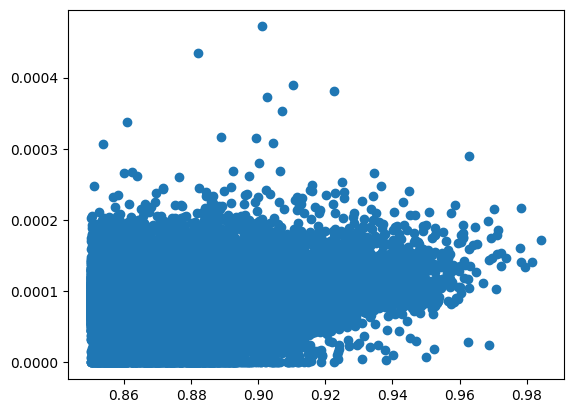

In [249]:
plt.scatter(taxa_match_vs_num_pairs_scaled['scaled_local_symmetric_percent_id'], taxa_match_vs_num_pairs_scaled['scaled_hit'])


In [250]:
taxa_match_vs_num_pairs_scaled.to_csv('/mnt/c/Users/Ryan/Desktop/l2t/taxa_pairs_16S_id_vs_num_pairs_scaled.csv')

In [252]:
from scipy import stats

In [254]:
res = stats.spearmanr(taxa_match_vs_num_pairs_scaled['scaled_local_symmetric_percent_id'], taxa_match_vs_num_pairs_scaled['scaled_hit'])

In [255]:
res.pvalue

0.0

In [256]:
res.statistic

0.21139857814996046